In [0]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

import cvxopt

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

In [0]:
def solve_mpc_collocation(A,B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0):
    """
    Here we want to do MPC with a collocation approach
    we assume that A and B are constant but Q, q, R, r and the bounds are given as list of vectors/matrices
    one per time step
    
    it returns a state trajectory and a control trajectory
    """
    # the number of states we will need to optimize for
    num_states = x0.size*horizon_length
    u_size = B.shape[1]
    # the number of control to optimize
    num_control = u_size*horizon_length
    # the total number of variables we need to optimize
    num_vars = num_states + num_control

    # the total Hessian of the problem (the quadratic part) [x u]^T Qtot [x u]
    Qtilde = np.zeros([num_vars, num_vars])
    # the total linear part
    qtilde = np.zeros([num_vars, 1])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    # we impose the initial condition x0
    btilde[0:x0.size] = -A.dot(x0)
    
    G_tilde = None
    h_tilde = None


    for i in range(horizon_length):
        # we put Q and R in the right places on the diagonal
        Qtilde[x0.size*i:x0.size*(i+1), x0.size*i:x0.size*(i+1)] = Q[i]
        Qtilde[num_states+u_size*i:num_states+u_size*(i+1), num_states+u_size*i:num_states+u_size*(i+1)] = R[i]
       
        # same for q and r
        qtilde[i*x0.size:(i+1)*x0.size] = q[i]
        qtilde[num_states+i*u_size:num_states+(i+1)*u_size] = r[i]
    
        # we construct the equality constraint for the dynamics
        Atilde[x0.size*i:x0.size*(i+1),num_states+u_size*i:num_states+u_size*(i+1)] = B
        if i>0:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i-1):x0.size*(i+1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i):x0.size*(i+1)] = -np.eye(x0.size)
        
        # now we construct the inequalities Gtilde [x u] <= htild
        G_tmp = np.zeros([G_bounds[i].shape[0], num_vars])
        G_tmp[:, x0.size*i:x0.size*(i+1)] = G_bounds[i][:,:x0.size]
        G_tmp[:, num_states+u_size*i:num_states+u_size*(i+1)] = G_bounds[i][:,x0.size:]
        if G_tilde is None:
            G_tilde = G_tmp
        else:
            G_tilde = np.vstack((G_tilde, G_tmp))

        if h_tilde is None:
            h_tilde = h_bounds[i]
        else:
            h_tilde = np.vstack((h_tilde, h_bounds[i]))
        
            
    # we transform our data into cvxopt complicant data
    Qtot = cvxopt.matrix(Qtilde)
    p = cvxopt.matrix(qtilde)
    
    G = cvxopt.matrix(G_tilde)
    h = cvxopt.matrix(h_tilde.flatten())
    
    Atilde = cvxopt.matrix(Atilde)
    btilde = cvxopt.matrix(btilde)
    
    #now we call cvxopt to solve the quadratic program constructed above
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(Qtot,p,G,h,Atilde, btilde)
    x = np.array(sol['x'])
    u = x[num_states:]
    x = x[0:num_states]

    return  np.vstack((x0, x.reshape([horizon_length, x0.size]))).T, u.T


In [0]:
class LIPM:
    """
    This class implements a linear inverted pendulum model - we will use it to simulate the walking robot
    """
    
    def __init__(self):
        """
        constructor of the class
        """        
        #gravity constant
        self.g=9.81
        
        #CoM height
        self.z_com = 1.0

        #integration step (100ms)
        self.dt = 0.1
        
        #
        self.omega = np.sqrt(self.g / self.z_com)
        
        #the transition matrices
        self.A = np.array([[np.cosh(self.dt*self.omega), 1./self.omega * np.sinh(self.dt*self.omega)],
                          [self.omega * np.sinh(self.dt*self.omega), np.cosh(self.dt*self.omega)]])
        self.B = np.array([[1 - np.cosh(self.dt*self.omega)],[-self.omega * np.sinh(self.dt*self.omega)]])
        
        # half of the size of the foot (i.e. the foot is 30cm long)
        self.foot_size = 0.15        
                        
    def next_state(self,x,u):
        """
        Inputs:
        x: state of the system as a numpy array (x,v)
        u: cop position as a scalar
        
        Output:
        the new state as a numpy array
        """
        
        return self.A.dot(x) + self.B.dot(u)
        
    
    def simulate(self, x0, controller, horizon_length, foot_steps, noise=True):
        """
        This function simulates the LIPM for horizon_length steps from initial state x0
        
        Inputs:
        x0: the initial conditions as a numpy array (x,v)
        controller: a function that takes a state x as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        foot_steps: an array containing foot step locations for every time step (this is used to ensure u is constrained to the support polygon)
        
        Output:
        x[2xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([1,horizon_length]) 
        for i in range(horizon_length):
            u[:,i] = np.clip(controller(x[:,i],i), foot_steps[i]-self.foot_size, foot_steps[i]+self.foot_size)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
            if i>0 and noise:
                disturbance = np.random.normal(0., 0.01)
                x[1,i+1] += disturbance
        return x, u


In [0]:
def animate_walker(plotx, plotu, foot_pose):
    """
    This function makes an animation showing the behavior of the LIPM with some graphics showing the CoP, etc.
    takes as input the result of a simulation (with dt=0.1s), the CoP position (plotu) and the foot step locations fn (foot_pose)
    """
    use_dt = 100
    
    feet_colors = ['b','g']
    c_foot_c = 0
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-0.2,9], ylim=[-.2,2.3])
    ax.grid()
    
    list_of_lines = []
    
    #plot the ground
    ax.plot([-0.1,8],  [0,0])
    
    #create the walker
    line, = ax.plot([], [], feet_colors[c_foot_c], lw=2)
    list_of_lines.append(line)
    #for the CoP
    line, = ax.plot([], [], 'or', ms=8)
    list_of_lines.append(line)
    #for the CoM
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the torso
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    #for the head
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the foot
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    com_height = 1.
    torso_height = 1.
    
    def animate(i):
        nonlocal c_foot_c
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        if i>0:
            if foot_pose[i] != foot_pose[i-1]:
                c_foot_c = (c_foot_c + 1)%2
                list_of_lines[0].set_color(feet_colors[c_foot_c])
                                        
        list_of_lines[0].set_data([foot_pose[i], plotx[0,i]], [0, com_height])
        list_of_lines[1].set_data([plotu[0,i], plotu[0,i]], [0, 0])
        list_of_lines[2].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height])
        list_of_lines[3].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height+torso_height])
        list_of_lines[4].set_data([plotx[0,i], plotx[0,i]], [com_height+torso_height, com_height+torso_height])
        list_of_lines[5].set_data([foot_pose[i]-0.15, foot_pose[i]+0.15], [0, 0])
        
        return list_of_lines
    
    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:-1])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))


In [0]:
def plot_results(x_real, u_real, x_plan, u_plan):
    """ this function plots the results of the simulations"""
    
    time = np.linspace(0,horizon_length*walking_model.dt, len(x_real[0,:]))
    plt.figure(figsize=[8,5])
    # plt.subplot(3,1,1)
    plt.plot(time, x_real[0,:], linewidth=6, label='Simulated CoM')
    plt.plot(time, x_plan[0,:], '--', linewidth=6, label='Planned CoM')
    plt.ylim([-1,10])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM position')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[1,:], linewidth=6, label='Simulated CoM Vel')
    plt.plot(time, x_plan[1,:], '--', linewidth=6, label='Planned CoM Vel')
    plt.ylim([-1,2])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM velocity')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time[:-1], u_plan[0,:] - foot_position, linewidth=6, label='Planned CoP in foot')
    plt.plot(time[:-1], u_real[0,:] - foot_position, '--', linewidth=6, label='Simulated CoP in foot')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) + walking_model.foot_size, 'k--', label='upper foot limit')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) - walking_model.foot_size, 'k--', label='lower foot limit')
    plt.xlabel('Time [s]')
    plt.ylabel('CoP position and limits')
    plt.legend()
    
    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[0,:], linewidth=6, label='CoM')
    plt.plot(time[:-1], u_real[0,:], linewidth=6, label='CoP')
    plt.plot(time[:-1], foot_position, 'k', label='foot position')
    plt.plot(time[:-1], foot_position + walking_model.foot_size, 'k--', label='foot boundary')
    plt.plot(time[:-1], foot_position - walking_model.foot_size, 'k--', label='foot boundary')
    plt.xlabel('Time [s]')
    plt.ylabel('Complete simulated pattern')
    plt.legend()


In [0]:
# first lets create a walking model
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(step_time / walking_model.dt)

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2) * 1 # Original Q
    #Q_nominal = np.eye(2) * 1
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)    # Original R
    #R_nominal = 2000 *np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))
#Q[horizon_length-1] = (10**9) * (np.eye(2))
# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)

# we now define a controller that will simply use the computed u as a control
feedforward_controller = lambda x,i: u_plan[0,i]

# we simulate the LIPM using the feedforward controller (no noise)
x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length, foot_position, noise=False)

x_final = []
x_pfinal = []
x_r = []
u_final = []
u_pfinal=[]
win = 48
count = 0
i = 0
while i < horizon_length:
  j = horizon_length
  window = horizon_length - i
  if i == 0 :
    x_p, u_p = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, window,x0)
    mpc_ctrl = lambda x,k: u_p[0,k]
    x_r,u_r = walking_model.simulate(x0,mpc_ctrl, window, foot_position, noise=True)
    x_pfinal.append(x_p[:,:win+1])
    x_pf = np.hstack(x_pfinal)
    x_final.append(x_r[:,:win+1])
  elif i <= horizon_length :
    x_p, u_p = solve_mpc_collocation(walking_model.A,walking_model.B,Q[i:j],q[i:j],R[i:j],r[i:j],G_bounds[i:j], h_bounds[i:j], window ,x_r[:,win])
    mpc_ctrl = lambda x,k: u_p[0,k]
    x_r,u_r = walking_model.simulate(x_r[:,win],mpc_ctrl, window , foot_position[i:j], noise=True)
    x_pfinal.append(x_p[:,1:win+1])
    x_pf = np.hstack(x_pfinal)
    x_final.append(x_r[:,1:win+1])
  else :
    x_p, u_p = solve_mpc_collocation(walking_model.A,walking_model.B,Q[i:horizon_length],q[i:horizon_length],R[i:horizon_length],r[i:horizon_length],G_bounds[i:horizon_length], h_bounds[i:horizon_length], horizon_length - i ,x_r[:,win])
    mpc_ctrl = lambda x,k: u_p[0,k]
    x_r,u_r = walking_model.simulate(x_r[:,win],mpc_ctrl, horizon_length-i , foot_position[i:horizon_length], noise=True)
    x_pfinal.append(x_p[:,1:])
    x_pf = np.hstack(x_pfinal)
    x_final.append(x_r[:,1:])
  i += win
  count += 1
  u_pfinal.append(u_p[:,:win])
  u_pf = np.hstack(u_pfinal)
  x_f = np.hstack(x_final)
  u_final.append(u_r[:,:win])
  u_f = np.hstack(u_final)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
#plot_results(x_real, u_real, x_plan, u_plan)
#animate_walker(x_real, u_real, foot_position)

The Animation and Graphs below give the Results of the MPC Controller

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABKPG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAmkZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuPX/iJj/8AFF0Vxavp60IbK
xvQxTQ3qXzv6l40b9L5tFkioGj/SuNECH4tcT69evnra7jsHLYjQ6ntiKTD/xH/x/ksaCz3unPnD
8QTymg8lvvz6IzX48k0yO3hz8bX/1+ETMj0fIIcWTWqTKldo7neVrBODMERfdWiAk3LJfzm6DaRl
4A1yT4J3q1mn/xn0piY9VLw04MDg487x1n0vNPJaWMojg2j+/4VNxqNJpjon7XPMFYxdqqpNJ41G
vvBI74586ynLnLMVhbJ9dVs94uFnDWL4RPGNIk/tn+4FkWDNCUjDBz9wre0888/IbVj0Gu7fY00w
m38m24OZSReP2UgWMav/tasYapLX9U5Ld0VBbtnhxkez6lXHCvvY3rL6GgDha/zIkQzg3sCAc7OJ
ZODa7Cu/YkyvoOCr9ZTHx7I/uS/pGlZlSnfe7t1NgrWzqzCO+WafqIRGe2T5ZGZgdTRvHNrVU5Us
XfWCebz+SoyE/DSmc+X4gNksG1ZxwkarPlCeeaehfwJNtOzhyUfj2dkE2cFREWsE/DA4Y/3WWn0Y
/oYXgK+IrXHtKCv2vncWui7anM3JYUY1+wqeL+VTWvPLpS71Be/6GzUG0VT6H/aXdi2F3RlsoYtO
fCaF+HdHPQPLf4eOn//6zmAbqtPSs4cNQp0smPp4XRvO+N+S6n6M3lRKb29TjXT0qVvAdmh65OqE
XUhtA3GbL4GCGX0V4l4yJcP+4V2uGP9BZpsZ1qmKJIRbR9yAa2WhjnVzdAE0d/O1gMvTYFRdCP/I
QXWVgZ8ivK2Fm/+Hvl0hJQ4qB4P+pTSrpjCcEZcHLRrs+bxJGHvV069TiP9sNhuDrWIbv1dGSAHa
zAB7QkClxXp6DlcBwh7AArdzJiD0fyqU3xx3HtjtQjmNaADGOSzR8v2z1C50t7QHMgUa2uj/7EUA
k1BLoIZH1n5xqRQOgV/5ihIsxHZMEIq4W6iQ6LsaTkKIKqgBLUqBQPvl+VaFT31Hflzo4Uh895kE
QPESHvSz8bw2QB3f/ow14KsZcUEApG6NyUO5g+W1ZMmnji3DLjvHqvjcwofvJb1fhWvA8z6DsLEC
muxMusWsBMGnEcH1GGPRmwJJYbIn73v8URsMr+YcKH7JHOrXZFiolIit45s1+mccKf8V2hmrVw0Y
YuIXIWHoWcKtP4oW4EFPRnlt5cicwlV/90JCQCZTADRpq8uCISkXcnWa2bwRVMaUIpzDDYlDtED4
E+K/+vdwkgbcc7QS92v9IFDHotMdJJZ0YLIV/5edRRHy7k57/dJw/QUBUCo21peWp+uf1VvAa1NQ
E/7EAAb6awPiwZ28jgBMn4HCW+wfomO55WsUwghPnwaI7qhw5gTjDTsDETjjr7LezgJeOrZsLfEo
KB8Qa6+FsWMwWGqBY/IQFRHvkES9iUs56+Hkzp5zeFt6x8//dFpZADaFKkfc0KrFB74GoynQAC9v
AqgxDgIp79KS1jYOgwzDCwqQxIo3Xb6YjiGaRlA3Tsz6FoSXRgpDmRSJ/jcSswNGXP3Gc5Zc7N3z
HqShsZdfl+bepKY7YTMYEciW6oKdAsgSvoKnkAAI54xpVcoY9W8fj8LuMLmwJPnk48/Inykdl7Ke
sPJ3ol665Cn+dXWn5twFtcSMbu7LOWaDOjOlZcoVV/y+evQ2BDGZtYooYwppJ5VWSEOQvOAXLmQz
VMz8L84nuQFKxd0GamCWLhncVzrM2R64waEgax7xZtV4JnU5DOriJMZreUJx3OW/5+UecqzGMmcF
02usD3IzeM07+T+QYdO27vACxOFzJRsiGI+XJDTG3+Eyebc7h3DJUfPamqyPt0FBYT1JCpGA5bW2
KOZMnA9YXi72GXXLhzUB3O7P+ZD4LtdBfo6PgxAqPjDyQnMTZ0cq+j9xMgUHBo7JszBlkyVuadBj
bytP3ykgm+mNjUySRHzfimSPXGIrEzgIqGgDsefZydTJCT3ZcLoB0T4au9/ZmSCaGqnubPloPAB4
oMcnIUz1NyWbcqeO/JvBMQ3KQh895FXM6zNfdIkZmryQwfLyo0JVo2efHoETZ+9SJriusGebWoDy
i6U4Q6regFlW4ih6opgqDakuxRoaB7B0YXMAse2cu5u+Vf8Wp2RlbzMXJJcCcsz2GN6OLj6Yg/8G
vEzanWzO/14EcgQpxy0YYUA64IjgPLEOFUbWXWK8S5PWZv7aDhZXZPm4F3k3Ss/TqAAnvSt8jV3W
FIaouGn653PufNMuk62m4dln9fn2P5oeqEuSNloeM93DfAoLWUJPWDPzw9ZuHRszTgS0KpkWmcfC
vTgcZeShDsL3n092uxk/i+uI0AKbBkI+e9E2tT56ODq/dWa0R8O7c3crKgHRiQHkA0S/QWe/bIB+
DBoKaQt8bXVQ8XiaPMzENB/VKXRQNHg+Cn7mv5aqNl2XuPGt+pj+yxdbgI8f/gsL8eQE55HS07Iv
PDrtD0elKYqYwb/EuvKkfZCfW34Je8LBpHUT6BTe+T//ri1yGVaC/ogFcH6rBfa+ShtaHQZg2pJR
tE5Esk7dFscSB6RhnW7wdnOAW/78jRTWas913jDUlecIejmxjIA3sdkLxwQ+l5NCLCIXgWTjqQd2
p/G7tdwWfVUs86961X45Paa8LYp8y5rxuxwLdZKkebbf3NBUyMEHnfCPWGsaZMA98r35dHKQhKLR
ZCZkwzIxDFO3MQdE0XGa4w2WDBZRgHnHwsA2bCS69u2XKbcvur7VC213hu6AJQ2tT17qdeK5R/o0
nHPCuzBovTCFpirXLIDN/eEKraZ/+50EU/EMjQ94yiqAxf+Pl5pnpTMelXZOgmQDLv6pRlrhPJ+W
LmHVFVgABYvB6mFUbTUCt

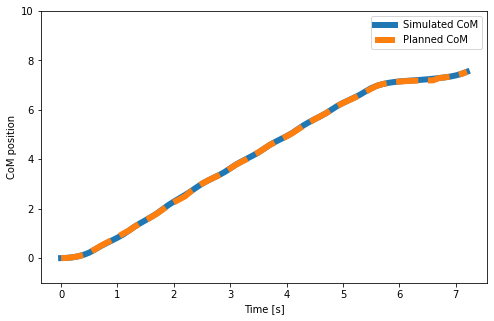

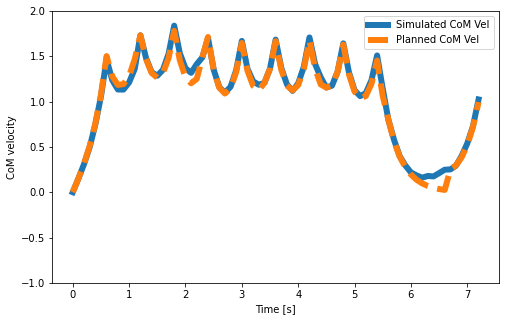

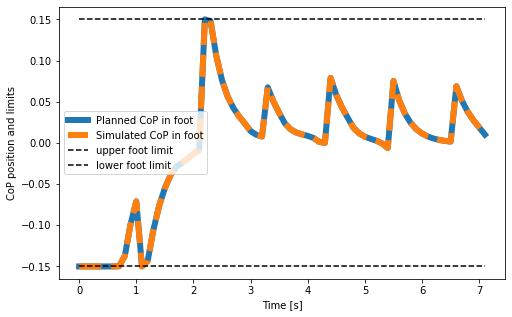

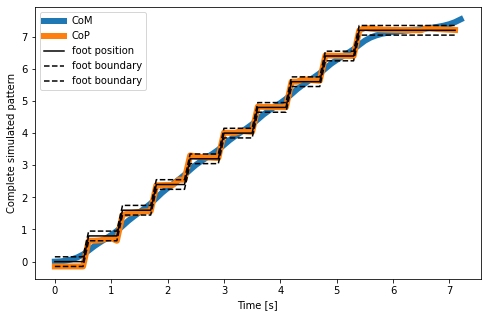

In [32]:
animate_walker(x_f, u_f, foot_position)
plot_results(x_f, u_f, x_pf, u_pf)

The Animation and Graphs below give the results of the feedforward Controller

## **Assignment 3, Question 2**

---



b)What is the shortest time horizon that you can use in the MPC controller while still getting a stable walking in a noisy environment? (the simulation is stochastic so you may want to test your algorithm several times to get an "average" behavior).

Ans: The shortest time horizon that we can use in the MPC controller while still getting a stable walking in a noisy environment is ***11***

c) Relate this horizon time to the duration of one step. How many steps in advance is it necessary to plan for to get a stable controller?

Ans: We need to calculate two steps in advance in order to be able to get a stable walking.

d) How different is the executed control compared to the originally planned one?

Ans: The executed control is relatively close to the originally planned one. There are points where it is sightly off from the planned control. This can be observed in the 'CoP postion and limits' V/s 'Time' graph

e) What happens if you change the weights in the cost function? What if you increase the terminal cost (e.g. to $10^9$)? Can you decrease or increase the receding horizon length? Describe qualitatively the behavior you observe.

Ans: 

The results below show the variations of the weights of the cost function:

1) Q = 10000  and  R = 1

In [26]:
animate_walker(x_f, u_f, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABMLW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAmUZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuPX/iJj/8AFF0Vxavp60IbK
xvQxTQ3qXzv6l40b9L5tFkioGj/SuNECH4tcT69evnra7jsHLYjQ6ntiKTD/xH/x/ksaCz3unPnD
8a9pa+v4CDFVv541x9GL3yBsQc2t8EyF5pi8+8ieJPpjsHOB3VNUqSLgO/UZgIECgIUaIlk/DSCh
BCY4AgmBftJzfe/+3klMSXwDkEG7tud46z6Xk5bbHTxHnTBWkf7/ew40cVEkw/uem5Rdhgf1JnZR
W194JHfHPnWU5dBYNTWSDvCRnUfRNF8Yw2pPR745BEyR7WxW38GN5MHP3Ct7TzzzxMRXBga7t9jT
TCbfyljFq9TCix6NQoPwtgZv95e03b7Zvh7op0AlXDjI9n1KuOFfdTeHH0NAKdl/mRIhnBvYEA3G
cSycG12Fd+xJlfQcFX6ymSuh4ekS/pGlZlR48r3SEQhWtnUcWJgb3ymzW89sgu2pHA6mjeKyHapy
pYu+poe3kA7xl0ZAgnDUIZDC07lvqWJGqz5Sa/FVQhnRIz7oIAWUslEXxeMYnuOgoxXxoFxqa9A5
pkSMt5fZIfT18yA5K1kHizSUyPV9dHb9GWOn6VsyDUEUNAKb5v+nXjcMsXm/L+HskjIh6UJnaoAk
OD/KYf/tY+cM3E71VCph9GBz2sKdpAe+o/aXU/Rm8qJU7z2czaelSuH6EOcq1VfNqVDZKoo+fy2T
S/4MEDEv3wTR9BBNh6PAz7LjgtM1L6QHQz37oGbxzaZaguxH8GmlkvfcBkyahADZmEfdrUPsG2ME
6H/yKcukJKHvxOpfsP5jkf/mHgy6F4/iv+X9H9lGJHkuQvD7zXVhnsib2Eg60p0Z4pKypWK/vFh7
F7zBdatYoxiQzZOV7JMv4gLUfDt9ivhUr0v5RNa2glmlYK/29lfHuom4NLm77TqjoooTkRCRkMvW
fnHJyC0o41vJeFmJVYfxf1esuSO8rbAEiiCqn1o9khFjzLPNNOm+Cvmh2ZjUOQ+e5TC2yhuFitS1
EgNB+kmle9/9vyIIxr5tWjckbo3JQ7mD4tjqFWaud+l7Msb6cFzWIk9N8h3VhJZzVkYsCu7tdiZd
YtYLopg/dpnYY9GbAklutloikY3dyiGYHTPuIQWMA0nMJHKXfpogAXv7a/0c45zvrNWrhpSfcQuQ
sPQs4VafxRZysjejPQRRTE5hKr/7oSEndymAGjTV5cEQlJLbus1s3giqYq3bjhmoSUO0QON70of6
E3CSBRoWxF73a/0gTDOxmbxu8eJgshogWIjFEfLuEZBR0nD9BQN0EE6jm8tUUxPqreA1qagJ/2IA
A301gfFgXP/HJD3SBzEt9u+dMTacXJVYSz5AAYt16mw5gS/Tg+cXvNhLm5lKf6zjAegUdY1zJItT
SXT10vKS53Z4SGqO+Cn735/wpip/nX4Ao1v1XhZcldL/8zPuigOlME5zvstHq1tv7JUvdOfR7BDS
i8VIQSY/+eNnKDDMKqT0hhb2N5J0o2zthkJch25nz6PgtUnVU6KfFJWjn+nr8cfFqBDQKcfS49ak
GGs5tU/0bU+BHhMxgRyJbqgwvs3Unm6I4AAGSOltOMBIFwDIU/FO1vLDZDptQ5GtPlI7L4V64ATv
RL11yFAi2etPzbgLa4xrkY5kfC4Dk37kVbBc9zl89ehsCGM1G1RQxVqaTyqskIchecAuWxDmqZn4
X5xPcgKVi7j568d0Uev4csyyKIPOZoSBrHvFm1XswkHcnkOrl/7iuYnHcf//jpR5v1eWTcAxWKW4
o6HCUwP6679l4LfDQsgzXYEHv+jLQtPKb3E1iHz1BZpyIN4E1nAEb9Ndgx1TwPJSg+6ZpHr/WjYu
970utLtsCIdQ5qAcK1F/uEXN4IE6NwRNIkdjq2aj+h3I75/lIvuHo1beCoyRCqHp5300TqJReMWC
VZebPMUsZqxHbfU3Y0dm/ydcP1jtn+ZefZydTJCT3ZYLkz0T4au9/ZmSCaGqyTy6KUqc5XFCgkBK
z3mB2H3TeyBSQA8pQ4j8PtdFwQ7ZyfpmzdT9vwSi95zadWbwN8vxvPYOdZrDiusGebWoDyi6U4Q6
regFlW4ih6opgqMGEuxRpQvIuGGvMAsexvx6g+Vv8Wp2SW2H57yS4E4poCHt6OLj6TSf9RdC/aHQ
Wlf58CN8YU45aMMKAdcERwHliHCqNrLrF0JcsxAx9hBwsro9zEC7yblWfp1AAT3pW+Rq7rCcIb7V
99pJCUoj0NJLwJspe+yqrHIE3Cpd7CDhHeq4f1NAlc6wvBp2sv8H3SWnH7E74hoQgq8Fhktyx/vi
TYqkQggwlEkCPeDyLrwGSULf5DR3sie5uAk9THo5YSTnmC/Vvubiiah77uEsL5+s/l37kqAwGmDm
tXg6Qj1VXhRx9z0mWDzZSyBEDCPSlMe4ZaqjpI7OPO3z7Kb9/K8LOeReS9f+PICc8jpadkXnh12h
6PSlMVMYN/iXXldPqV5k78Err0zSJ+UAVOLK0//lVZ+mFpKqsOrHj8WTtTBJV0e1D6orjsoS3raz
Sdui2OJA9Iwzu+pdiPriv8oLRTWaYr13jDUlecIejmxjIA3sdkL0biQdpnPVX6Ju283q3IO7SPHh
rO4LPqqWede9FtpZdUCsHA0+Zc143Y4FuslSPRkb7ASbMiW8e2aRczM938gCfy6OB8P9VkJmTDMj
EMU7cvx0TRcZrjDZYMFlAMuhQHLhv6kS69u2XKbcPur7VC213hu6AJQ6tT17qdeK5R/rLsHPCuzB
ovTCFpik11Dh+6iI7Pb/3CeLW0SjDM79069Di/40befo16TorcHfJAe3PMxDHdzBPlPbMNUcV5wA
Fi8HucRlAW4raOmdCS8lZ

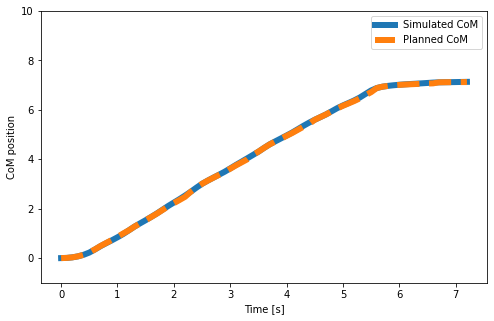

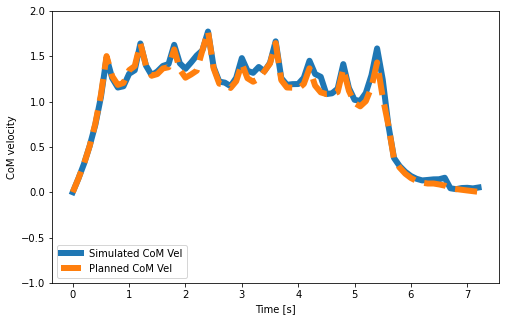

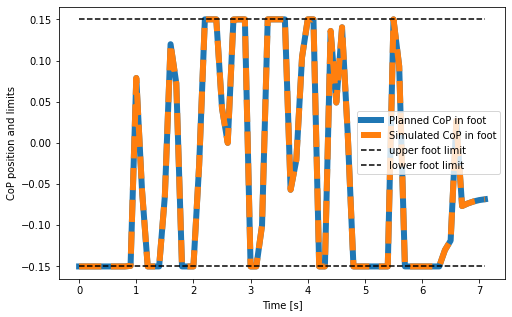

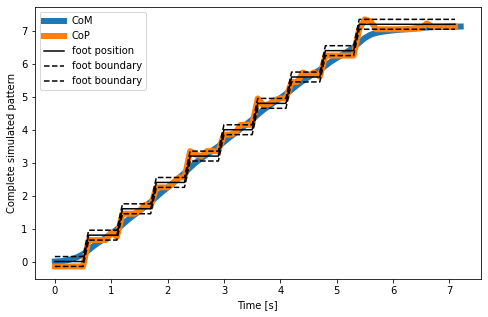

In [17]:
plot_results(x_f, u_f, x_pf, u_pf)

2) Q = 1  and   R = 2000

In [28]:
animate_walker(x_f, u_f, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABKbm1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAmGZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuPX/iJj/8AFF0Vxavp60IbK
xvQxTQ3qXzv6l40b9L5tFkioGj/SuNECH4tcT69evnra7jsHLYjQ0TcwV7D/w1nuK4aHyrHjp8mO
EB9vg/AfAVZnKwdOvJEajDLjPYwnswiJBiRBfRceX49kc51InEDSBPtGhICBiUFsEo74cXvhla05
v3xX87eAp8mdyD4G7Xiu1D6XmnktVM9UqVVgx8qL/+iV0nhShATtUImFYxdqqpNLsTVXrfS8IAmO
gb/TwVMVsJbwkZ1H0TRfGcAieMZWUQRMke1sb/X9vvDBz9wre0888+IaQex1T7CSW5WrLu0xzyke
HE/ZSBYxq/+1qxjSktf07dS0y2ns+yVmN77qVccK++DesvoXgkLMRFiRDODewICBkMlk4NrsK79i
TJ1T3xWCF0+lR57yVw/xWCrvtmCvu7X8GqXX5ny4M7l7bRVPGxVWczhBjl3Gc2J1QMB3tfMwqjBb
QKjGCITnzCknw0f9Nt4jfqp/6K7ymDWYYY+WX5U8EJUdJ87657AuGy8Rkhy2tdsIuLK2Z+uXeofW
PYq8894Q8RH/qrnI1v6pj2towgOWHd7wpNiKUFqR//oj02+tyghz63TMy9U+wbUcfdyT/9IooGNv
U2wHh65w4Oe1aatIT1N9KH5uW8pNzcte3LpNLrfB+7sprSLZVfNzMuBON4+gEm42DhMt06nZskR9
BBdhgjOzqSLgtM1L6QHiWFiRWbxzjB5Weu37+mlpvfcBkyahADZ1mcRLbi/cK0Kjp9/9YnR0xKVG
4/jJ4YG4pw7878TJ/l08AJvMLOTC1GX1Euxo2vag19BI9xHBzsLBUfxU1GsPZG0Kio76bQ4rLGRp
Ppaf1f74Ei7uP5l06f3efsL+qNBkqgjgkJo0lvDNYoUduQUf9k8gEmoJdBDI+s/OR7SB0Cv/MUJF
mJlYf6r1usuSO8rbAEiiCqoIsaN56Ir+wFFALrCO5Ur21jGmAM/0A0zfJ4b7+FTvv/3vodkzC08O
cUjdG5KHcwfNBcmTTxxbhlx3j1Xxu6RBvJb1fhWvA81FjsLECmuxMusWsRPh/XUF1GGPRmwJJrWK
0RSMbu5RDMDqwUP2Y4uOejwouwkHsfotKJa/7Ml5zvrNWrhpdqP3uQsPQs4VafxUo6A6+jPNgF/X
MrPh1Wjswp9ymAGjTV5cEQlIzbbXD9lpdKjrczJPw2I3hMCTQmsG/4hkFCm1yIsd73cTjGSeoP5N
UXCxi/1b9W3kuPreDnrrco3aB1Q/n4rA5XURNaU0mXYNy1o79MG/8VcN9NYHxYmD/xqQzy8cJyTY
O8j7QB78qkgFBmUVVGXpXyWhgbvfZkfhYJo8k0UkKxzIwjAEEEUV7NDPtEhPXu9pWj3+PUsOnKPY
CV9QmMlEH/50bbmbJxhJHdDZM1cVUYjTTPUW9TwKpBoffbw0py/SRRHj0HHCERWEPWTi/H2Hc1Xi
2ss4iS4awuyc9sufX6qTg0PeWvxx8WRaOL8jlZG6opWc2qf6NqfAjwmYwI5Et1Pof8cbrWEV8VYT
1HdloZmeBsUiocpOOZg3zToSs1fYiWQYSYRPbl+2ZBoe9EZFy+Z0ey6poXIrb2e6cakBD6jSzlmg
zozpWaBmvchDPXobAhjMw1ysH1E/8wqZasZ2Wn0IqJoBYh0jLV1q/IClYu3RtCPdFHr+HLMsxxzm
waEgax7xZtV25KtVZC5HbobKNyhJyV/6UJ6Z0eqYbnDeseF1mEJwd0fZ204kpItKLv34RZLjX2iO
izgPWSMxfldkud8Lj0AcexWlpce7xrh4jNU8TOgdbx1UU/GR9swkag9dmH/egl9dE2D+u/v6/tiK
8uDI+qDlbtwB+JYnBZ0csKhIpPvtjQxXHWEtqrffpLQ0DDHNTkJK0uK2jH5WuH6x5ABs3Vk5Opkh
J7sHLkz0T4au9/ZmSCaGyyuOXBoPAB4oMcnJK2ESD98RHvZApIAeUocR+z9dFwQ7ZyfpmwceGRNh
rvKjQmfzX3y/G89g52rBcV1gzza1AeUXSnCHVb0Asq3EUPVFMFQnUl2KQqjENXRhcwCx7uyvqD5W
/xadfAJQfnvWiTBuL/0fPKmILgcH/EhwzOh1a6f57BG5cKcctGGFAOuCI4DyxDhVG1l11OF7jigS
/gQnSsWN83su8m5Vn6dQAE96Vvkau6wnusdkvD0d9gRNlwmgKbvj5dpTD6DUu1GuFBkgNqNb31zw
4yeAB/2yo13SWnXu/P86r4gq8HIw0e//ynY7F3/ggwlEkCPeHOer+BJsc+6csqUp+mpNKGvkRyGM
jZTMbufiiah77uEsNe+ngF37lPAyOmDmtXg6Qj1VXjJljsCSWDzZSyBEDAcwksaJb2MMWCW152+f
ZTfv5XhZzyJ2Cwvx5ATnkdLTvXp+W0mccQUpipjBv8S68qx9kJ9bfgkz2wA//lAFTiyxP/5VD9RT
i7BRJsY8fsDx9rPET9odBmDaklG0TeeaTt0WxxIHpGGjxXBW3oygf35Gims0xXrwSGpK84Q9HNjG
QBvY7IXosOFBdz+1a6G283q3IO7SHHhrO4LPqqWede9Wt5YkDasHhJcy5rxuxwLdZKkei432DjCe
KjyDyJN2tikWcPrQq/kAT+XRwRlfqshMyYZkYhinbnXtCaLjNcYbLBgsoxKVWl83LgjwDiG/e3bL
lNxNhIdDdba7vmJRXfrFU9e6nXiuUf6FTNNILswaL0whaYT0Ri8+132D+f+L1S4hsqOMpUWKoRx/
yo28/R1nnRW4O+SA9ueZaYcYa2U/li5h1RVYAAWLwfQomUBbito6Z0JMqMpPQyVfEvTKJQwfYOgc
zKPojutmAFkrIi7w5n5X/

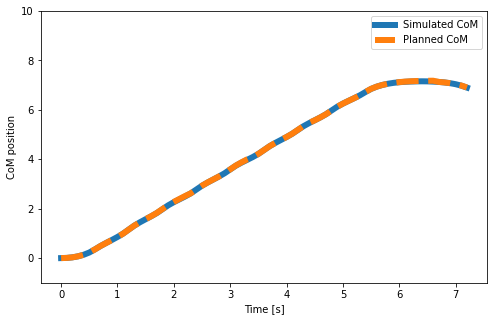

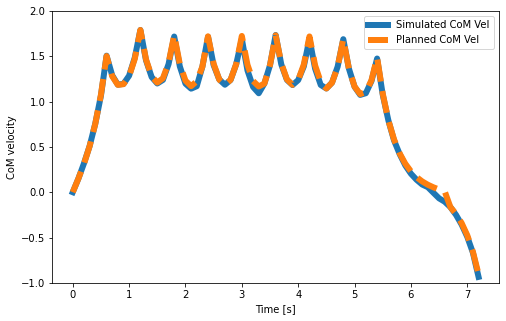

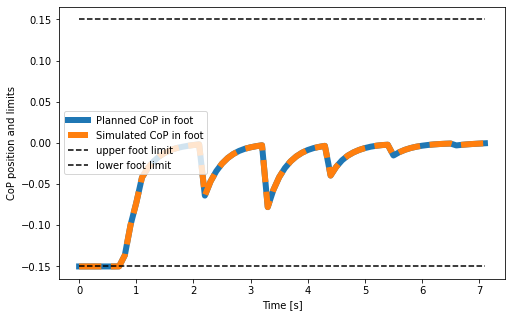

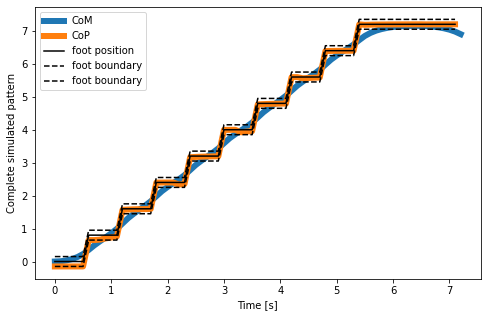

In [19]:
plot_results(x_f, u_f, x_pf, u_pf)

3) Increasing Terminal cost to 10^9 

In [30]:
animate_walker(x_f, u_f, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABPW21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAmTZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuPX/iJj/8AFF0Vxavp60IbK
xvQxTQ3qXzv6l40b9L5tFkioGj/SuNECH4tcT69evnra7jsHLYjQ6ntiKTD/xH/x/ksaCz3unPnD
8QTymg8lvvz6IzX48k0x2c65VE1/1+BUS9kwkEOLJrVQwSu0dzvK1g8lmCIvurRASfEkv5zdBtIz
GIa5J8E71azT/4z6UxMeql4acGBwced46z6XmnktLHFywbR/f8Km41Gtox0T9rnmCsYu1VUmk8aj
X3gkd8c+dZTlzlmKwtk+uq2e8XCzhrF8InjGkSf2z/cCyLBmhKRhg5+4VvaeeefkNqx6DXdvsaaY
Tb+TbcHMpIvH7KQLGNX/2tWMNUlr+qclu6Kgt2zw4yPZ9SrjhX3sb1l9DQBwtf5kSIZwb2BAOdnE
snBtdhXfsSZX0HBV+spj49kf3Jf0jSsypTvvd26mwVrZ1ZhHfLNP1EIjPbJ8sjMwOpo3jm1qqcqW
LvrBPN5/JUZCfhpTOfL8QGyWDas44SNVnyhPPNPQv4Em2nZw5KPx7OyCbOIeQqPuf+gBxPdME+gI
tJIUqjlKDuGSiVrDiCO/Cwe3ZLCjGv2KsSH5VNS+6DuIWXtMnobNQbRVXif9rYLrYXdF7xS8iWqz
Qvw7o57x8wTZGFL//OU3/avNnrOHDUKdLJi9PEJXnfG/JdT9GbyolRLcbFrp6VK/iOmxyiKPiLqQ
2gbjNk/KIyi4T7ZqWSimgWCRGWJK/s02M61TFEkI+tUvefH7M2Dq5ugCaV//AB3MhJiouhH/kHjs
2y88AnmuF0f9w8bpvJSO0Dwf9OmR0IjZYSZcHLRrs+bxHeHvED/wwYES7GkB1rEN4GsnJCw3Gzo3
qN6HTi8z4nNr+IewAK3cyYhjf64JZ3w7lUoKwFJCA1w4D+NZb8n5ihdaW9oDmQKNbXR94BM9Lxad
FtGzWPzUT532lHGt5LwstMGvZks+t1Eh0XY0nIUQVVBcL5BqeffMQqjNTx1SufLRwpD57zTooeIb
T+K25ruRQBnf/tALiOsZchkApG6NyUO5g+aEkYmnji3DLjvHqvjdLofvJb1fhWvA81c9aLECmuxM
usWsf/5OuoLqMMejNgSSy23ARSMbu5RDMDqn3EIHqqmuyLFRKRFbxzZr9M46M/5zvrNWrhpP6cQu
QsPQs4VafxRhwIKejPTDr/XMrPh1WjswwLVg4VAjqe33jHGXDVlw/ZaXSo57gg22oSUO0QPnUD8f
8Qx/vix472hJ7tf6QKS1RaY6ySzowWRAIC0RiiPl3RB3+6Th+goKUcntrS8tUfPt9heA1qeQJ/2I
AA301gfFgzt5HACZSvzEwysERMdzytYphBCfPg0R3U1hzAnGGnYGI/HHQbQy0lxK8owX72IeGTIL
m0VrbCxmCw1FLa1CAqI98aiXsSlnPXw+nhPObwtvWQH/7qaAEA2hSpH3NDmxQe+BqMp0AAvbwKoM
RA7CaOH+a42DoMMwyh1+dYkAiWiZtz1wXav0I3oexnBfn8WgSZW4v8biVmBoy5+4znLLnZu+do/F
FSs5tU/0bU+BHhMxgRyJbqgp0CyBK+gqeQAAjnjGlVyhj1bx+PxFO1vLDYCJtQ5GtPlI7MKDYRJi
2Jxmgn8DvB5KQuT3TjSDC7u7LOWaDOjOlZgr7oVgtwJXdp9FRKvFQdQbpJ5VWSEOQvOAXLmYzVMz
8L84nuQFKxd0KamCWLhncVzrMyx64waEgax7xZtV4JnU5DOriJE5reUJx3Nz/6KUedEzGMmFGXXI
8LjRm8Zp38ojq9xOF/Fx6ltgKHose6HV8tS59LSwcDtllAgXzd48Ax9ufksV6l31L6dSmFRY+EXP
9N8boOIJ1dwZTmxrEZnL/2nN2dgQ//1Vk0ZVHS+d9IPL+ZlK0CMXfIiXkeYKeuU9SFw3qeKP3uQd
5zVtiL1oaBhjmp8xz1xrBb0fsTOAioYT5l59nJ1MkJPdk0uTPRPhq739mZIJoap+45cGg8AHigxy
ci4bx5ZJtum9kCkgB5Shw7qHvIq5nWZr7pESk/w/BKL3nNpzRGzz49AibP3qNNcV1gzza1AeUXSn
CHVb0Asq3EUPVFMFQjnj3Z4L2HsHRhcwCx64iHqD5W/xanZHLlMxcklwJ0zPYY3o4uPonz/2l0L9
odBHP/rwI2hhTjlowwoB1wRHAeWIcKo2susV+9ENnzf20HCyuJ+bgXeTbyz9OoACe9K3yNXdYUgz
KdAPn04+581JvsmurU2CHz4PM/mhpfy5I2Wh4z3cNpXolv5EBrBV5nxLVXMD1hqxT5xyOHOPhXpw
OQvJQh2F7z6eSJ9mWQ0t1i5DPXUbBB7QfEFGNHtaI+HduP8MLoBNHuuAoeV/eDe/bIB+DBoKaQt8
bXVQ8XidQqyqzg/VKXRQNHgCACcu4ZaqOIKpf90t+pj+yxdbgI8fXgsL8eQE55HS07IvPDrtD0el
KYqYwb/EuvKdfZCfW34JfDPBpHUT6BTe+f//ri48xjKC/ogJhX7+TxURvTVaHQZg2pJRtFAEsk7d
FscSB6RhnPe5WV+j9/35Gims0wLrvGGpK84Q9HNjGQBvY7IXinm/K28+cHai23m9W5B3am8bu13B
Z9VSzzr3rVfjk9prwtinzLmvG7HAt1kqR5vF/dImHeqSIPPGZDQjVwj8gCfy6OCARaLITMmGZGIY
p25qtx1p6zXGGywYLKAN1g7gPYU1KM2ioy5Tdd91faoW2u8N3QBKD+/bREc9P/pLXAZMVILswaL0
whaYq3y0NFn6bYI7YX/pczMQu828zv3Trz/X/x8vNM9IJD0q7J0EyAZd/XwGuaZClPbMNUcV5wAF
i8HwoVRtNQK26Aw4viAzb

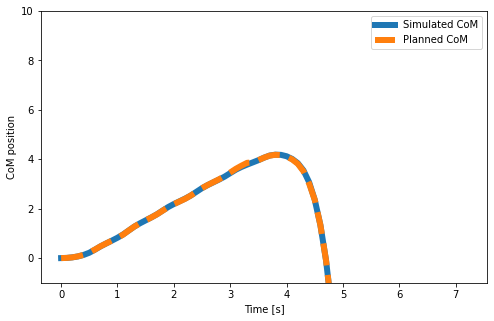

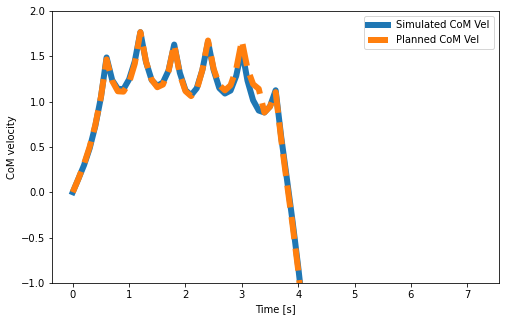

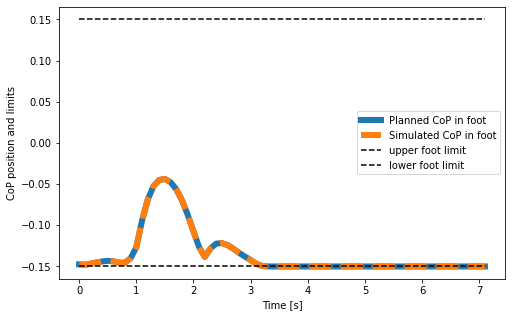

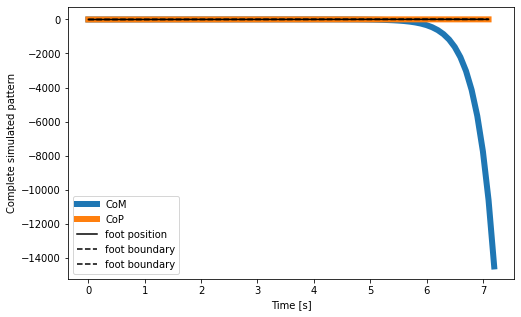

In [24]:
plot_results(x_f, u_f, x_pf, u_pf)

When Q is increaed with respect to R it can be observerd that the control is very irratic in nature. However, the goal of controlling the biped is still achieved. In the second case when R is greater with respect to Q we see that the control of the biped is very smooth. Finally, when the terminal cost is increased to 10^9 we observe that the biped walks steadly right up until the end where it looses stability.  

The length of the horizon length can be increased without loosing stability however when decreased below 11, the biped looses stability.

Horizon length = 50

In [34]:
animate_walker(x_f, u_f, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABGIW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAmHZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuPX/iJj/8AFF0Vxavp60IbK
xvQxTQ3qXzv6l40b9L5tFkioGj/SuNECH4tcT69evnra7jsHLYjQ0TcyUEH/h3/mNU3Fqcejm2za
gPuTUiR4ArM5WDp15IjUYZcZ7GE9hmplq6QX0XqHRcgaEn0RZp2DiJCPfRoSAginAsS71oMSCKv5
i1b+/Sa4fsKX1hMgok+ruoR2z7+tvPxu8aQ1+C6/8VUFzul0fHFiEpZE85cypHSTgJqC1vpeEATH
QN/pIKmK2Et4SM6j6JovjL+1Nm8cPoImSPa2N4y3nGeY0/Im3XRxnyZxYPY6p9hJLcsA+sWA0pUj
w4n7KQLGNX/2tWL6Ulr+nbqWmWyto2bdmS7ylXHCvvDz8/+sO7Ra9ZYkQzg3sCAdZDJZODa7Cu/Y
kyvoN+0OhdPrqcUj04f4ozT9vnX7dtclufJB90DQ2iYHKqmiACpl2PlNVSjq2K1fP//F1cNQBdGO
392T/giUg69zUsBR2BTP4OAwok/WMv7mg2Fs1AyMMM0bHEEeaYeVDSLSfHMykcF8g8IhRd80/CZe
36tA2Lwo1QutAHVkxSo+witJ9zT5lLdIeWbmglMPWJWTZvJE7+8ALLLrU3GToStaiyHpQmdx88lm
9jM7f/x9MUN+o+VxzqmATpZMesfV9FYVSQ/Ny3lJubkzGu7cBdb4Q7WGgmkU92DuAsZGbjNoxM4M
6vzzOcslFNAsEkAvu1S5zUZ1qmKJISbWuR6dfUzjY7m6AJoh+9t4ZemwKi6Ef+QcfNyUmkuPSMe9
J/+P54h7Vk7QSclAhDhjLZggUuMMBWMeTjshVqXZYUGIQvmA3cbwApyS9/5wLVPmAvxU4DJvhPUW
PIrsYU4VljI0n0tPa7+qEF6/G+zoHXPFAAx+qNBlQZJmRfDlcu8M1ihR25BR/3AyZLxadFtGzWPz
UsyYWlHGt5LwstCS6XkxlbqJDouxpOQogqp6M9tfVkVuz4IccUH7n3TxxU+goCElAcys4mP7MAAQ
m/7GkCocpaxTOKRujclDuYPodMYVZq536XsyxvpwXWEJJpvkO6sJLObozNFiBTXYmXWLWUSd1Kez
oCGzPaKcwR3A0RSMbu5RDMDnWx2NH8F0nMJHKXfpogAXv7a/9KN5zvrNWrhphuP3uQsPQs4VafxV
UiKr94pR4f+uZWfDqtHZhZWrBwqBHU9vvGOLDI6S3N4IqmFR6/DDDYlDs+VfJ2x/+vdwkgiKP8lJ
XYosGCnrSaC9eWYjeMXx2rJE6/qsy85iMGbBLEC98c9cx0eqjOD/XIQ51tB4fIN/4q4b6awPiwZ2
8jQD4VX447PhN2o5eFV0EAWBlNmiQVRdzFKo/DU7FqgVveUcwfJzgZIjAEEu2dv4DCAiokj+na3t
K0fFabH/n+sTnSl0Y4iwnOv/dIV1iC0yDlbic9tWo6MRpplQAFKeBVGGn2/oglOX6SKI8eg4wC9R
YQ9ZOL8fYdzVeLY0XC+UyCW0WmwfyW7Wgc6rQctfjj4soXxatSeZEqDxzap/o2p8CPCZjAjkS3U7
7gB1ID3q0W2sqaLVYz7mttcgdu3sw/NSZP0Wb9/4fAl5ObcTGz4CCGyyxtZl6JsnDGuDqQSkwg1Z
DhsCwhKRHZqgzozpWSiKrAdDPXobAhjMv1ysGk3GNf05JePRq1/UMrz2tcuZjZIol1gf6+21rTHd
FHr+HLMslE+QwaEgax7xZtVyzSsnfPaSqSVbiuYkp7P9hW9Mgk2kHFyZ8bxYoht1so8NCyDNdgG/
4pXr4C1RNFGfhOWA1RJuyXO42CmBv+naWlx7vGuHiJPMBK6QvNhCEbuMj7ZhI1B67dL+9BKg6Kcg
+exZ2f2LP8uDI+qDlb/o8/nk+lNW3ijKxnkZC/kon6ST7wNvxXMM8tDQMMc1OOArS4raMfla4frH
jC2zdWTk6mSEnuwaGTPRPhq739mZIJobJK45cGg8AHigxychDYRBR3tum9kCkgB5ShxL/1eAq5nW
Zr7pEhrr3ibDXeVGhMZ27z49AibP3r8HFFv7nm1qA8oulOEOq3oBZVuIoeqKYKgapLsUZTYw9hhr
zALHuTQ+oPlb/Fp176rczFytEmC6X/o+eVMQXBhP+JDhmdDq0zfz2CN8YU45aMMKAdcERwHliHCq
NrLrhVEuOVQo+BCdKwcLzey7yblWfp1AAT3pW+Rq7rCk36Us1lQO5tJ1IBgyUs6h8+DzP5nBOOLb
AuSiH7tHgFUoJYmzjLhXJaq5gesNEUVmiw1rR8K9OZP1Mc/ewvefTybbkRKv5lGgBpbjgE+rMunv
C81yrpWvonJ5pE98ZDvf/pAUAAfi+3ftkJ/B/87H1jwdIR6qr17EL82TLhnuprxClgFUYmN7bzZf
KosieNb9TH9li63AR4gfFb/x5ATnkdLTvXp+W0mccQUpipjBv8S68p39kJ9bfgj+7k4YdL2g4eqO
f/9WBTRO7gL+iAfOfhmUdr8mm1odBmDaklG0NItLxVxifbjsmw/fgvB2gHFb/vyNFNZq1a8TgfnB
KhD0c2MZAG9jsheWL58IFresMAtt5vVuQd2SXG7tdwWfVUs8697VX578DasCRnWfBzW+/TO7d4uF
Iv9y2P41JkdN8rrVhscIUJvYwQ9TpLzaINkWQmZMMyMQxTtzdbjrT1muMNlgwWUYWyh/9UPSrfuv
btlym657q+1Qttd4bugCS/V+2iI56f/SWuFR9iQXZg0XphC0xTXMmtPnc5Ome753f/3Cbb6xLHYh
M79068+h/7rthJL4z50VuDvkgPbnmXdGWuCjbrbMNCtj5wAFi8IeYVRtNQK26Aw4v6p4PyWnbQWu
dMr2DoHMyj6JWXDaACWw4

Horizon Length = 8

In [36]:
animate_walker(x_f, u_f, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABBfG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAmJZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuPX/iJj/8AFF0Vxavp60IbK
xvQxTQ3qXzv6l40b9L5tFkioGj/SuNECH4tcT69evnra7jsHLYjQ6ntiKTD/xH/x/ksaCz3unPnD
8QTymg8lvvz6IzX48k0x2c65VE+VgL1lVbKPTUuV0I213ewK6D+Y7uzLiQ/M5zL1nGKfAKh6NQHW
Sm7i+AtkmkmRxBvx/0GSooy1adGCTUiQrcK3Y+0+MeDXznkv88Gg/zpv+c4t5doBcHwF0w5grGLt
VVJoUAZBd6SffHPnWU5c/wExWwlvCRnUfRNF8YovFK14x9BEyR7WyNT284zzGn5E266OM+S/IOIT
Yib7GmmE2/lG2xqkeHE/ZSBYxq/+1qxcfciP5TLZaZbIKNxKzG991KuOFfeOFcWeLvtZV6yxIhnB
vYEA82GSycG12Fd+xJlfQcFX6ymQNihOrR/ishnlShW92kQPQrWzqxvzv2s0aqv4sPQis/DsShiG
S0q1cKieY5oPHOsHTZkVYUXNRfh+q1zmkBTbt+IB/5RjW+L/ghLlPrshQ3xpNoiuxaTcL4F4YVVN
kNGwWC7AJ4zLFSIvDfOEyUsw3CXYIEFpnosUTpWSIEOUJXmu8QC/9NRZVpPW1dg/7S8dvnkeAySH
luIDE0f3SrGwVHo2eijyn/7WUbhCosTsaQ3z9WFSH1pXgzGApyH5uW8pNzcny5oubT0qVvH0/vCc
WY/m1KhslTUfP3tKpf8GCBiX74Jo+ggmrdHgZ9lxwWmal9IDpJjde74dS45KguxH74Sc1DxJ10nW
uHnwqsOcq8TMnitjPqW7LibHb9qVUuROv37XCUFyrggzLg5Znb1w+2+lvYElZe7j+ieqfea6tDec
6GDVg9nEZ4pMWtqqs+TaTPXg6fE2MYkM2Tleyln+ICtqKKRs7kL5nKYRfWbUYRN3rHUl9bfHuom4
NLm77TphSr0xZ59A8rhc/OSZsB0Cv/MUJFln+XTeavdZckd5W2AJFEFVQixRX/bAuOazkDTV3MyE
ineniD8NtelGduCCBhrr8nbea5vYxYv/4yzRYcpmAq6sGRif+J3MH0BkRiaeOLcMuO8eq+N5cCR6
b5DurCSzmx+dda7u12Jl1i1lbvJ11BdRhj0ZsCSf+YwEUjG7uUQzA6NsduuAq/AejtPYTKpPfKgm
mWHllDpz2taJOk8vG0VXNFbxa0KIJWCIzDowJoKpb8HZb/ha1tyb22NuTKK1y78Ub39WsImjXsyQ
6GrBBx+iO/63ldyXhKnvp6Svv/wVm9zd0oSN9RUxLSZH9zBB970QbAnNf/0VXaP0JyAuPZBPEYU1
n3J+WqYN/4q4b6awPiwNXz7/tm2+B6g14Ahl7LBAYcn5JilUNvi7AhfH84DXOha3Ju9HjFOVVmdO
pmceNLR7mplTvBtu9Q8dZBp5C4PNGuf/sobRBpXA6S1P9r3n2Kw6ofoNZPEvgS5XyA0YRsN68bIM
5QUmPFKIqB4jxLv1rN3o27rWYxX9OtRdEaIdFDnhEfBoe0s/jj4tDVnBiaa7ylyalDj/rIjb1JTH
bCZjAjkS3U81QO7twDhyL2uEDhsLsArVD33sUfdjhDW7QmTEycogYgpqHOty2EMai0oAcAZujpX3
3o82680elpPMI4+FYQTDpYamCvIifBhCbkNzLHDI43kzs4pHTjJvrtphKNX9jLpfQGfGlq4PMqCl
iSN701M6FYnj6bVU2d3zA1afmdGjE97GFjM3S3wvJy/yzTvUVM8WbOlZuBUz6aaB68cpkQxB5EeS
I2ximveyc3q5OEdwLkQ1+V2S54ChC+j+vU1ZL9TPkHOhKF7eX9o3reNIqrazeaRUnyj12dP9WF3+
CanzM9PuvxE9ba7ZH/Swf3cAH0SnYBQGjLePuszqckMg/rw6rBPSWhoGGOanKEm4awW9H7EzgIqK
me19boW2G98L7yTzwp3DSkhFmVKR1jiBjKgcSlTnK4oUEgeOuOWT0G0feoFJADylDiQSvKAychIT
X3SIw/uhcwJXeRrBM6u7wC8X57BztfUE3rBfXgVAeUXSnCHVb0Asq3EUPVFMFRfzk7s9TmMFHpIu
YBYw6x3y+DdB4tOvgAQkXYBQ/8vjMd6PQttoMwb/dQ4L5P4tx3+BRyMmCnHLRhhQDrgiOA8sQ4VR
tZddMkEEqdSfyiaS5ZaHKbOeOerGAqgCJ5wkgZWK24eqKPL9H3yvphuqpRIJ5NDWMmcxZ/X59dD4
YKRqj7j1P6THqbyYnOUBjq7PI/povjw0bbfUCUyLwashXoTcCC/je/zTjUuEj62+pCsS1FkNLfIP
GTUIY+N5h5VqLX0X9akTCZ5peMSA8gMQf4Z5Q7ZAPwYNBTSFvja6qHi7kbjarNaP6pYetOjYcvfq
c1bLVPbu+sSnN5V0/ZYutwEeN7wWF+PICc8jpadkXnh12h6PSlMVMYN/iXXlMfshPrb8Ero3QIch
oAqcWST/1vekKfjXHTrUu5T/IoJH9+fUiywrAL0lA1pUvhEhYHLB/MCxcIlAfZMKDIE/vyNFNZpg
oh8SQWJtQh6ObGMgDex2QvMd+fy5We7UtOdWG5LEme5Iy9kIoEe7nyUhrSjnlUNI4Nvr8T/FqXag
fr4RyfXukzcQBN+ZUFC1bOLnhnIVPs5DI8/kBky2MuoL8S+IVNqwv/OEruShTvUX1B4W1O5MFZK9
r8ComOj4K2xXAAmmL+kHnQKDIsKZ5JJ3IsiE0r9gpkka0MsMy3VZF0AVDI8NHWs55+Nn6zjGCs7b
426DF4gzqrxhhv/I1sJ09v79LhhVvoyolE1qZBQYyZaXT9UZyptSwJdimkynW0RkHQ3oiwiAxH5C
GdEEjHZHwx4JIbxigAfkA